In [1]:
import time
start = time.time()

from lasy.laser import Laser
from lasy.profiles.gaussian_profile import GaussianProfile
from lasy.optical_elements import ParabolicMirror
from lasy.utils.laser_utils import get_w0
from lasy.utils.grid import Grid

import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c

import full_field
import axiparabola_theory as axi

dim = "rt"

In [2]:
l_w = 10.54e-7
f0 = 7e-2
delta = 2e-3
w = 1e-3
tau = 1.5e-14
E = 6.2
des_dt = 1.39e-16 # PIConGPU Standardwert
des_dt = 7.3443e-17 # spezieller Wert
w0 = f0 * l_w / w / np.pi
vf = 0.98 * c
print("w0 =", w0)
print("w/w0 =",w/w0)
if dim == "xyt":
    npoints = (int(2*w/w0), int(2*w/w0), 200)
    npoints_prop = (int(10*w/w0), int(10*w/w0), 200)
    hi = (1.1*w, 1.1*w, 4.5*tau)
    lo = (-1.1*w, -1.1*w, -5.*tau)
elif dim == "rt":
    p_per_r = 1.0/3
    picpoints_per_p = 2
    print("points in file:", int(1024/picpoints_per_p))
    spacing = 0.1772e-6 * p_per_r * 6 # PIConGPU Standardwert
    npoints = (int(2*w/spacing), 3000)
    cut_frac = 0.3
    hi = (2*w, 21*tau)
    lo = (0., -15*tau)
    offset_frac = hi[1]/4 / (hi[1]-lo[1])
    print(offset_frac)
print(npoints)

print(np.pi*w0**2/l_w)
print(100000*des_dt*c)

print("time:", (time.time()-start)/60, "min")

w0 = 2.3484903402640077e-05
w/w0 = 42.580545589452335
points in file: 512
0.14583333333333334
(5643, 3000)
0.0016439432381848056
0.0022017657492894005
time: 0.058043686548868816 min


In [3]:
profile = GaussianProfile(l_w, (1,0), E, w, tau, 0.0)
laser = Laser(dim, lo, hi, npoints, profile)
print("time:", (time.time()-start)/60, "min")

time: 0.1328250487645467 min


time: 0.2261514902114868 min


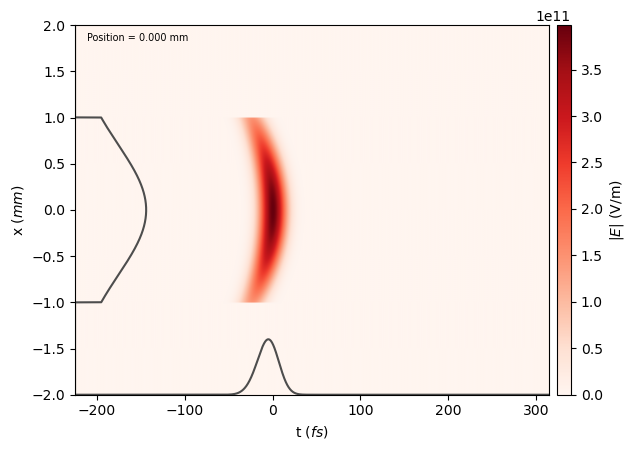

In [4]:
axiparabola = axi.Axiparabola_Ambat(f0, delta, w)
laser.apply_optics(axiparabola)
laser.show()
print("time:", (time.time()-start)/60, "min")

0.0683560567618152
Available backends are: NP
NP is chosen


  0%|          | 00:00<? [?it/s]

Extracting full field
Displaying


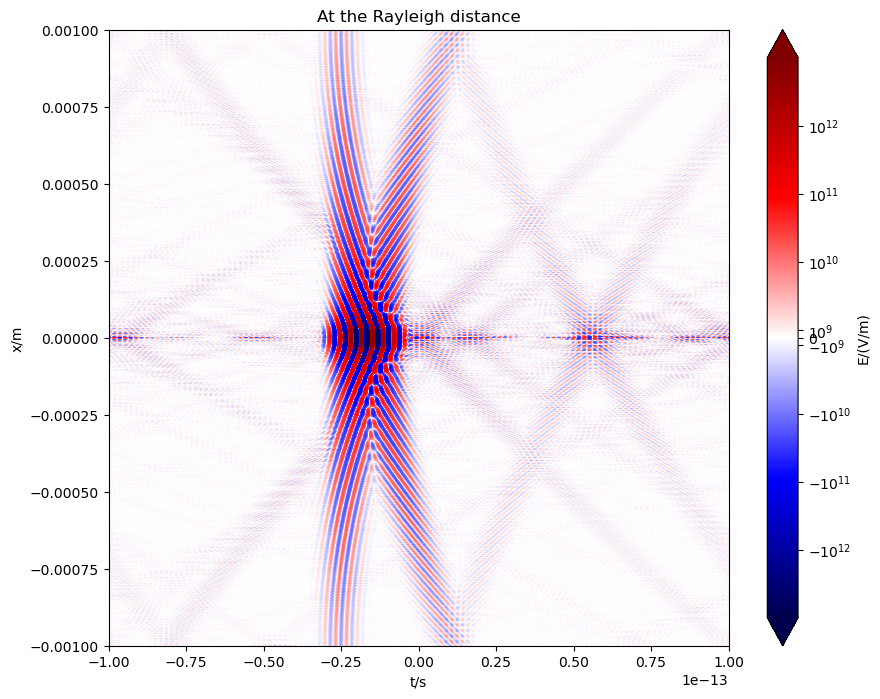

time: 11.425651196638743 min


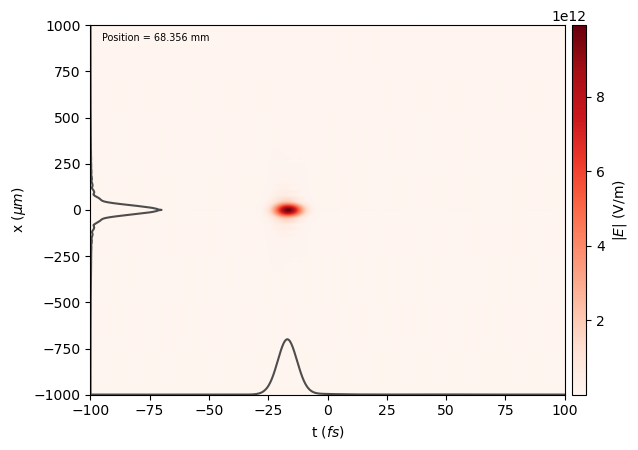

In [5]:
zr = np.pi * w0**2 / l_w
l = f0 - zr
print(l)
newGrid = Grid(laser.dim, (0., -1e-13), (1e-3, 1e-13), npoints, n_azimuthal_modes=1)
laser.propagate(l, grid_out=newGrid)
full_field.show_field(laser, linthresh_frac=0.001, title="At the Rayleigh distance")
laser.show()
print("time:", (time.time()-start)/60, "min")

In [6]:
N = 10
ws = np.zeros(N+1)
wes = np.zeros(N+1)
wps = np.zeros(N+1)
zs = np.zeros(N+1)
ts = np.zeros(N+1)
tes = np.zeros(N+1)

ws[0] = get_w0(laser.grid, laser.dim)
zs[0] = l
tps = full_field.get_tpeak(laser)
dist = 2*zr/N

Step 1 of 10:
Available backends are: NP
NP is chosen


  0%|          | 00:00<? [?it/s]

time: 21.197067793210348 min
Step 2 of 10:


  0%|          | 00:00<? [?it/s]

time: 29.97255841890971 min
Step 3 of 10:


  0%|          | 00:00<? [?it/s]

time: 38.56992271741231 min
Step 4 of 10:


  0%|          | 00:00<? [?it/s]

time: 47.35914075771968 min
Step 5 of 10:


  0%|          | 00:00<? [?it/s]

time: 52.97836927175522 min
Step 6 of 10:


  0%|          | 00:00<? [?it/s]

time: 57.495416518052416 min
Step 7 of 10:


  0%|          | 00:00<? [?it/s]

time: 62.027755673726396 min
Step 8 of 10:


  0%|          | 00:00<? [?it/s]

time: 66.56469265222549 min
Step 9 of 10:


  0%|          | 00:00<? [?it/s]

time: 71.05137626727422 min
Step 10 of 10:


  0%|          | 00:00<? [?it/s]

time: 75.53250950177511 min


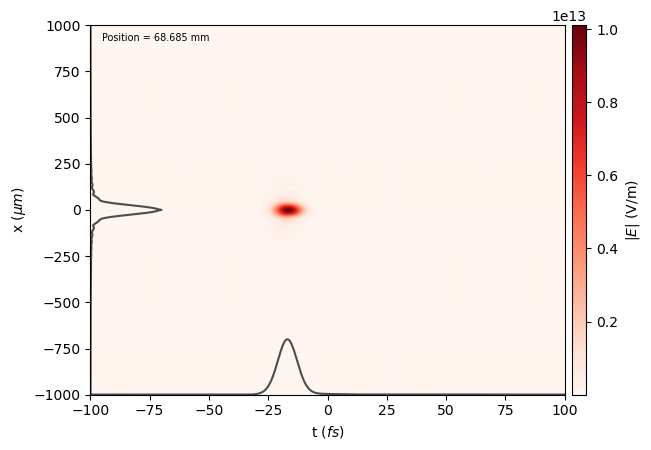

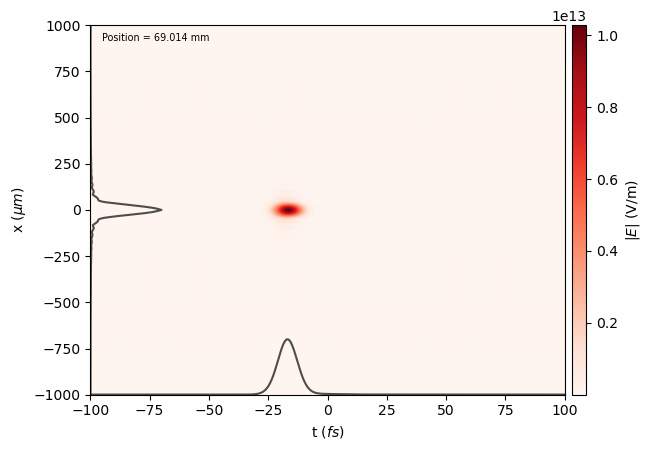

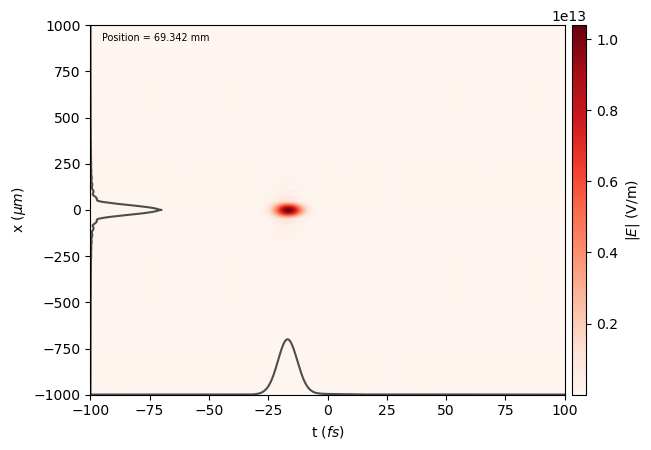

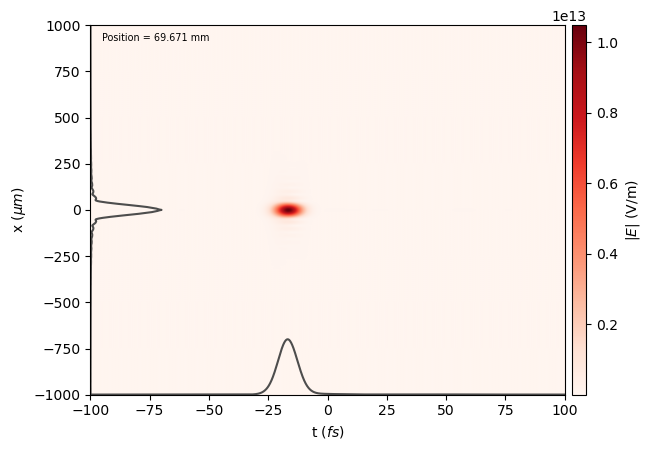

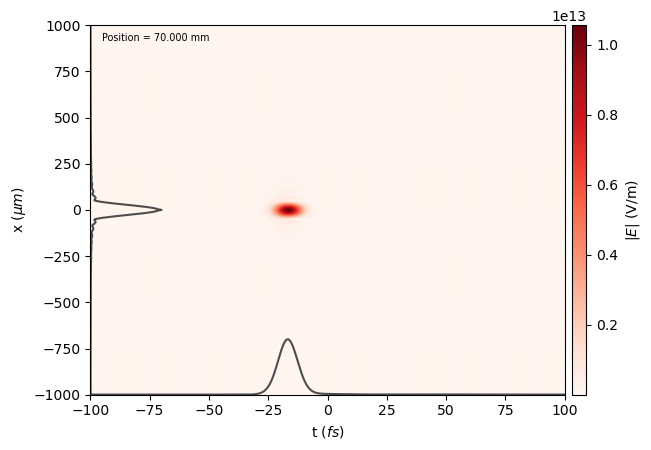

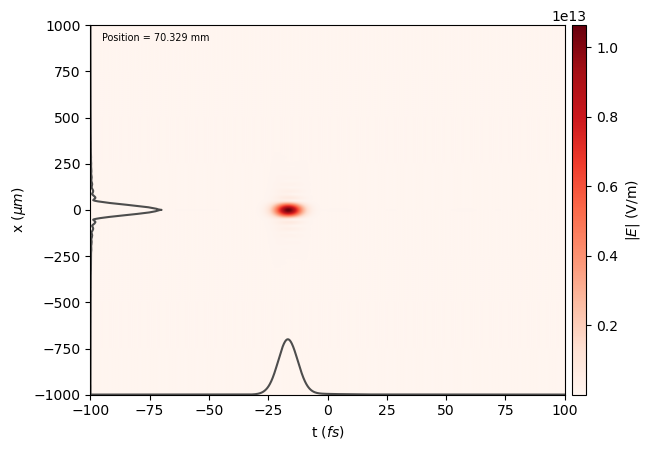

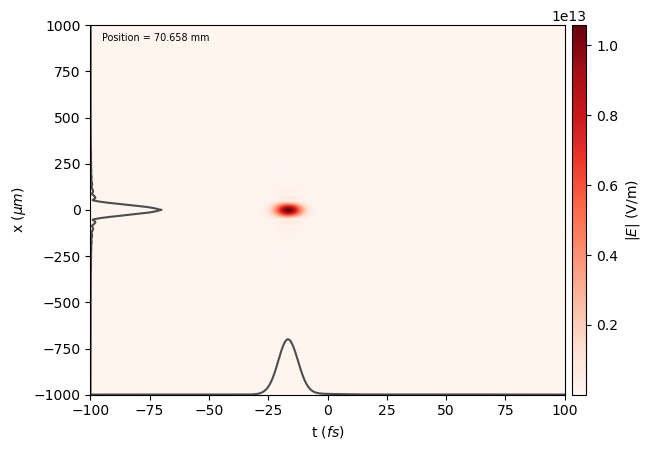

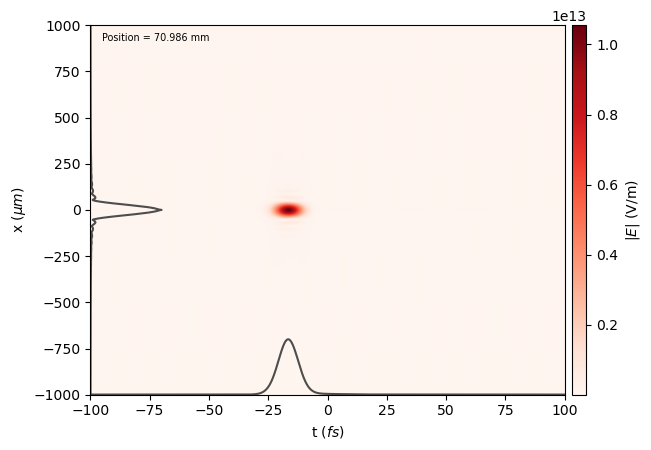

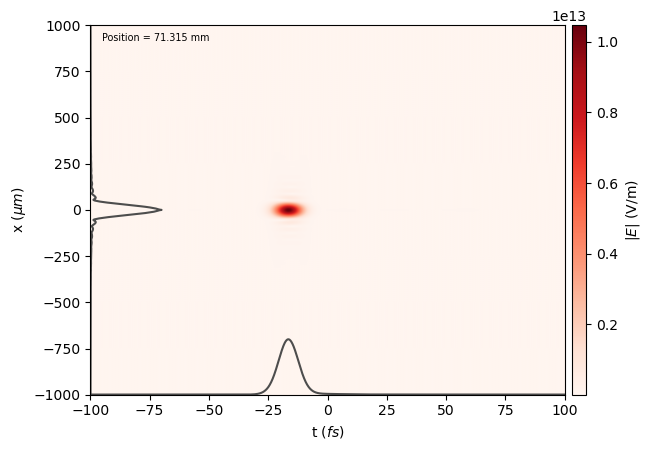

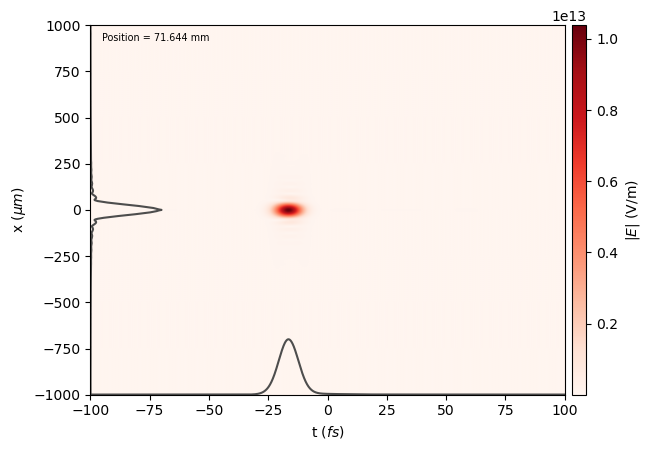

In [7]:
for n in range(N):
    print(f"Step {n+1} of {N}:")
    laser.propagate(dist)
    laser.show()
    ws[n+1] = get_w0(laser.grid, laser.dim)
    zs[n+1] = l + (n+1)*dist
    if zs[n+1] > f0:
        wes[n+1] = axi.wz(zs[n+1], axiparabola, l_w)
        tes[n+1] = axi.tfz(zs[n+1], axiparabola)-zs[n+1]/c
    ts[n+1] = full_field.get_tpeak(laser) - tps
    print("time:", (time.time()-start)/60, "min")

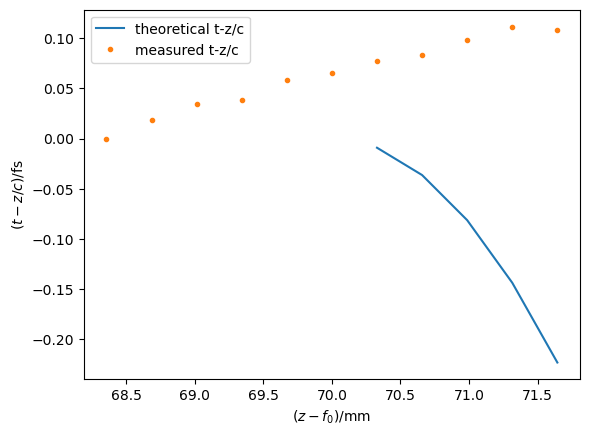

In [8]:
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(zs[N//2+1:]*1e3, tes[N//2+1:]*1e15, label="theoretical t-z/c")
ax.plot(zs*1e3, ts*1e15, ".", label="measured t-z/c")
ax.legend()
ax.set_xlabel("$(z-f_0)$/mm")
ax.set_ylabel("$(t-z/c)$/fs")
plt.show()

Text(0, 0.5, '$w/\\mu$m')

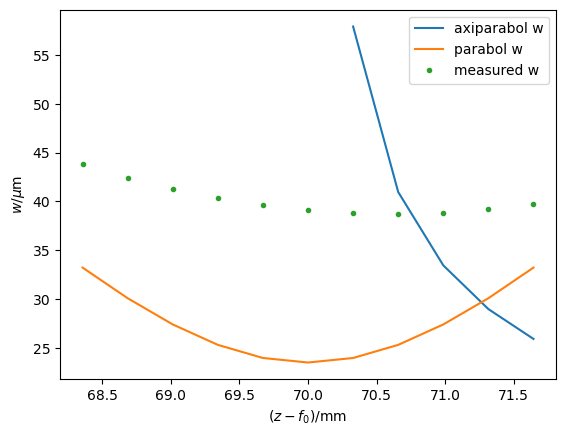

In [11]:
wps = w0 * np.sqrt(1+((zs-f0)/zr)**2)

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(zs[N//2+1:]*1e3, wes[N//2+1:]*1e6, label="axiparabol w")
ax.plot(zs*1e3, wps*1e6, label="parabol w")
ax.plot(zs*1e3, ws*1e6, ".", label="measured w")
ax.legend()
ax.set_xlabel("$(z-f_0)$/mm")
ax.set_ylabel("$w/\\mu$m")

In [10]:
print("time:", (time.time()-start)/60, "min")

time: 76.94255617459615 min
